# 5.4 池化层---缓解卷积层对位置的过度敏感性

在二维卷积层里介绍的图像物体边缘检测应用中，我们构造卷积核从而精确地找到了像素变化的位置。设任意二维数组X的i行j列的元素为X[i, j]。如果我们构造的卷积核输出Y[i, j]=1，那么说明输入中X[i, j]和X[i, j+1]数值不一样。这可能意味着物体边缘通过这两个元素之间。但实际图像里，我们感兴趣的物体不会总出现在固定位置：即使我们连续拍摄同一个物体也极有可能出现像素位置上的偏移。这会导致同一个边缘对应的输出可能出现在卷积输出Y中的不同位置，进而对后面的模式识别造成不便。

## 5.4.1 二维最大池化层和平均池化层

同卷积层一样，池化层每次对输入数据的一个固定形状窗口（又称池化窗口）中的元素计算输出。不同于卷积层里计算输入和核的互相关性，池化层直接计算池化窗口内元素的最大值或者平均值。该运算也分别叫做最大池化或平均池化。在二维最大池化中，池化窗口从输入数组的最左上方开始，按从左往右、从上往下的顺序，依次在输入数组上滑动。当池化窗口滑动到某一位置时，窗口中的输入子数组的最大值即输出数组中相应位置的元素。

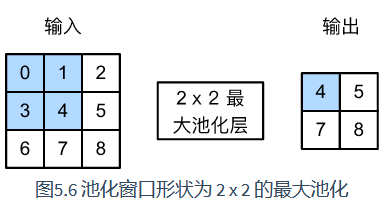

图5.6展示了池化窗口形状为2×22×2的最大池化，阴影部分为第一个输出元素及其计算所使用的输入元素。输出数组的高和宽分别为2，其中的4个元素由取最大值运算max得出：

$$max(0,1,3,4)=4,$$
$$max(1,2,4,5)=5$$
$$max(3,4,6,7)=7$$
$$max(4,5,7,8)=8$$


二维平均池化的工作原理与二维最大池化类似，但将最大运算符替换成平均运算符。池化窗口形状为$p×q$的池化层称为$p×q$池化层，其中的池化运算叫作$p×q$池化。

现在我们将卷积层的输出作为2×2最大池化的输入。设该卷积层输入是$X$、池化层输出为Y。无论是$X[i, j]$和$X[i, j+1]$值不同，还是$X[i, j+1]$和$X[i, j+2]$不同，池化层输出均有$Y[i, j]=1$。也就是说，使用2×2最大池化层时，只要卷积层识别的模式在高和宽上移动不超过一个元素，我们依然可以将它检测出来。

In [4]:
# 池化层的前向计算实现在pool2d函数里

import torch
from torch import nn

def pool2d(X,pool_size,mode='max'):
    X=X.float()
    p_h,p_w=pool_size
    Y=torch.zeros(X.shape[0]-p_h+1,X.shape[1]-p_w+1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode=='max':
                Y[i,j]=X[i:i+p_h,j:j+p_w].max()
            elif mode=='avg':
                Y[i,j]=X[i:i+p_h,j:j+p_w].mean()
    return Y

In [5]:
X=torch.tensor([[0,1,2],[3,4,5],[6,7,8]])
pool2d(X,(2,2))

tensor([[4., 5.],
        [7., 8.]])

In [6]:
pool2d(X,(2,2),'avg')

tensor([[2., 3.],
        [5., 6.]])

## 5.4.2 填充和步幅

同卷积层一样，池化层也可以在输入的高和宽两侧的填充并调整窗口的移动步幅来改变输出形状。池化层填充和步幅与卷积层填充和步幅的工作机制一样。我们将通过nn模块里的二维最大池化层MaxPool2d来演示池化层填充和步幅的工作机制。

In [7]:
#前两个维度为批量和通道

X=torch.arange(16,dtype=torch.float).view(1,1,4,4)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

默认情况下，MaxPool2d实例里步幅和池化窗口形状相同。下面使用形状为(3, 3)的池化窗口，默认获得形状为(3, 3)的步幅。

In [10]:
pool2d=nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [12]:
# 手动指定步幅和填充
pool2d=nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [13]:
#指定非正方形的池化窗口，并分别指定高和宽上的填充和步幅

pool2d=nn.MaxPool2d((2,4),padding=(1,2),stride=(2,3))
pool2d(X)

tensor([[[[ 1.,  3.],
          [ 9., 11.],
          [13., 15.]]]])

## 5.4.3 多通道

在处理多通道输入数据时，池化层对<font color='blue'>每个输入通道分别池化，而不是像卷积层那样将各通道的输入按通道相加。这意味着池化层的输出通道数与输入通道数相等。</font>

In [14]:
#将X和X+1在通道上连结来构造通道数为2的输入

X=torch.cat((X,X+1),dim=1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [15]:
pool2d=nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])